# Laboratory work 2: Systems of linear equations

---

## Work objective:

1) To solve a system of linear equations using 2 direct methods: Gaussian elimination and LU
decomposition (if possible), and 3 iterative methods: Jacobi method, Seidel method, successive
over-relaxation method;

2) To verify obtained results via calculating residuals.

## Given linear system

\begin{cases}
    ax_1 + x_2 + ... + x_5 = 1 \\
    x_1 + ax_2 + x_3 + ... + x_6 = 2 \\
    x_1 + x_2 + ax_3 + x_4 + ... + x_7 = 3 \\
    x_1 + x_2 + x_3 + ax_4 + x_5 + ... + x_8 = 4 \\
    x_1 + x_2 + x_3 + x_4 + ax_5 + x_6 + ... + x_9 = 5 \\
    x_2 + x_3 + x_4 + x_5 + ax_6 + x_7 + ... + x_{10} = 6 \\
    ... \\
    x_{k - 4} + ... + x_{k - 1} + ax_k + x_{k + 1} + ... + x_{k + 4} = k \\
    ... \\
    x_{93} + ... + x_{96} + ax_{97} + x_{98} + x_{99} + x_{100} = 97 \\
    x_{94} + ... + x_{97} + ax_{98} + x_{99} + x_{100} = 98 \\
    x_{95} + ... + x_{98} + ax_{99} + x_{100} = 99 \\
    x_{96} + ... + x_{99} + ax_{100} = 100 \\
\end{cases}

Where $a = 10$.

## Used norms

Let $x$ be a n-dimensional vector and $A$ be a matrix of size $n \times n$.

### Norm №1

\begin{equation*}
    \|x\|_1 = \max\limits_{i \in {1, ..., n}} |x_i|
\end{equation*}

\begin{equation*}
    \|A\|_1 = \max\limits_{i \in {1, ..., n}} \sum_{j = 1}^{n} |a_{ij}|
\end{equation*}

### Norm №2

\begin{equation*}
    \|x\|_2 = \sum_{i = 1}^{n} |x_i|
\end{equation*}

\begin{equation*}
    \|A\|_2 = \max\limits_{j \in {1, ..., n}} \sum_{i = 1}^{n} |a_{ij}|
\end{equation*}

### Norm №3

\begin{equation*}
    \|x\|_3 = \sqrt{(x, x)}
\end{equation*}

\begin{equation*}
    \|A\|_3 = \max\limits_{i \in {1, ..., n}} \sqrt{\lambda_i (A^{\ast} A)}
\end{equation*}

In [11]:
import numpy as np
from matplotlib import pyplot as plt

## Helper functions and classes

In [12]:
def norm_1 (obj):
    return np.linalg.norm(obj, ord = np.inf)

def norm_2 (obj):
    return np.linalg.norm(obj, ord = 1)

def norm_3 (obj):
    return np.linalg.norm(obj, ord = 2)

def direct_method_residual (A, b, method, norm):
    return norm(A @ method(A, b) - b)

def iterative_method_residual (A, b, method, n_iters, norm):
    return norm(A @ method(A, b, n_iters) - b)

def check_correctness (A, b):
    if A.shape[0] != A.shape[1]:
        raise RuntimeError("Solving systems of linear equation with non-square matrix"
                           "is not supported")
    if (A.shape[0] != b.shape[0]):
        raise RuntimeError("Sizes of matrix and vector mismatch")

class Iter_Method:
    def __init__(self, method, name):
        self.method_ = method
        self.name_ = name

class Norm:
    def __init__(self, formula, name, color):
        self.formula_ = formula
        self.name_ = name
        self.color_ = color

## LU decomposition

In [13]:
def check_if_LU_defined (A):

    for i in range (0, A.shape[0]):
        if np.linalg.det(A[:i, :i]) == 0:
            return False

    return True

def LU_decompose (A):

    dim = A.shape[0]
    L = np.eye(dim)
    U = np.zeros((dim, dim))

    for i in range (0, dim):
        for j in range (0, i):
            L[i, j] = (A[i, j] - sum(L[i, k] * U[k, j] for k in range (0, j))) / U[j, j]
        for j in range (i, dim):
            U[i, j] = A[i, j] - sum(L[i, k] * U[k, j] for k in range (0, i))

    return L, U

# A is supposed to be a lower triangular matrix
def forward_substitution (A, b):

    dim = A.shape[0]

    x = np.empty(dim, dtype=float)
    for i in range(0, dim):
        x[i] = b[i] - sum(A[i, k] * x[k] for k in range (0, i)) / A[i, i]

    return x

# A is supposed to be an upper triangular matrix
def back_substitution (A, b):

    dim = A.shape[0]

    x = np.empty(dim, dtype=float)
    for i in range (dim - 1, -1, -1):
        x[i] = (b[i] - sum(A[i, k] * x[k] for k in range (i + 1, dim))) / A[i, i]

    return x

def LU_decomposition (A_, b_):

    check_correctness(A_, b_)

    if not check_if_LU_defined(A_):
        raise RuntimeError("LU decomposition for given matrix is undefined")

    A = A_.copy()
    b = b_.copy()

    L, U = LU_decompose (A)

    return back_substitution(U, forward_substitution(L, b))

## Gaussian elimination with pivoting

In [14]:
def swap_rows (A, b, i, j):

    A[[i, j]] = A[[j, i]]
    b[i], b[j] = b[j], b[i]

def find_pivot (A, i, j):

    pivot_row = i
    pivot = A[i, j]

    for row_i in range (i, A.shape[0]):
        elem = A[row_i][j]
        if (abs(pivot) < abs(elem)):
            pivot_row = row_i
            pivot = elem

    return pivot_row

def Gaussian_elimination (A_, b_):

    check_correctness(A_, b_)

    A = A_.copy()
    b = b_.copy()
    dim = A.shape[0]

    for row_i in range (0, dim - 1):

        pivot_row = find_pivot(A, row_i, row_i)

        if (row_i != pivot_row):
            swap_rows (A, b, row_i, pivot_row)

        for j in range (row_i + 1, dim):
            m = A[j, row_i] / A[row_i, row_i]
            A[j] -= m * A[row_i]
            b[j] -= m * b[row_i]

    return back_substitution(A, b)

## Jacobi method

In [15]:
def Jacobi_method (A, b, n_iters):

    check_correctness (A, b)

    D = np.diag (np.diag (A))
    M_0 = np.linalg.inv (D)
    M_1 = M_0 @ b
    M_2 = M_0 @ (A - D)

    x = np.zeros (A.shape[0])
    for k in range (0, n_iters):
        x = M_1 - M_2 @ x

    return x

## Seidel method

In [16]:
def Seidel_method (A, b, n_iters):

    check_correctness (A, b)

    LpD = np.tril(A)
    M_0 = np.linalg.inv (LpD)
    M_1 = M_0 @ b
    M_2 = M_0 @ (A - LpD)

    x = np.zeros (A.shape[0])
    for k in range (0, n_iters):
        x = M_1 - M_2 @ x

    return x

## Successive over-relaxation method

In [17]:
def successive_over_relaxation (A, b, n_iters):

    check_correctness (A, b)

    dim = A.shape[0]

    w = 1.1
    x = np.zeros(dim)
    for k in range (0, n_iters):
        for i in range (0, dim):
            sigma = A[i][i] * x[i] - sum(A[i][j] * x[j] for j in range (0, dim))
            x[i] = (1 - w) * x[i] + w * (b[i] + sigma) / A[i, i]

    return x

## Input data

In [18]:
dim = 100
a = 10

A = np.diag(np.full(dim, a, dtype = float))
for i in range(0, dim):
    for j in range(max(0, i - 4), i):
        A[i, j] = 1
    for j in range(min(dim, i + 1), min(dim, i + 5)):
        A[i, j] = 1

b = np.arange (1, dim + 1, dtype = float)

## Results

### Residual of direct methods

In [19]:
norms_list = [Norm(norm_1, "$\|x\|_1$", "red"),
              Norm(norm_2, "$\|x\|_2$", "green"),
              Norm(norm_3, "$\|x\|_3$", "blue")]

print ("Residual of Gaussian elimination:")
for i in range (len (norms_list)):
    residual = direct_method_residual (A, b, Gaussian_elimination, norms_list[i].formula_)
    print (f"- norm {i + 1}: {residual}")

print ("\nResidual of LU decomposition:")
for i in range (len (norms_list)):
    print (f"- norm {i + 1}: {residual}")
    residual = direct_method_residual (A, b, LU_decomposition, norms_list[i].formula_)

Residual of Gaussian elimination:
- norm 1: 1.4210854715202004e-14
- norm 2: 2.291500322826323e-13
- norm 3: 4.9451681530410434e-14

Residual of LU decomposition:
- norm 1: 4.9451681530410434e-14


- norm 2: 1.4210854715202004e-14
- norm 3: 1.6919798895287386e-13


### Dependence of residual of iterative methods on the number of iterations

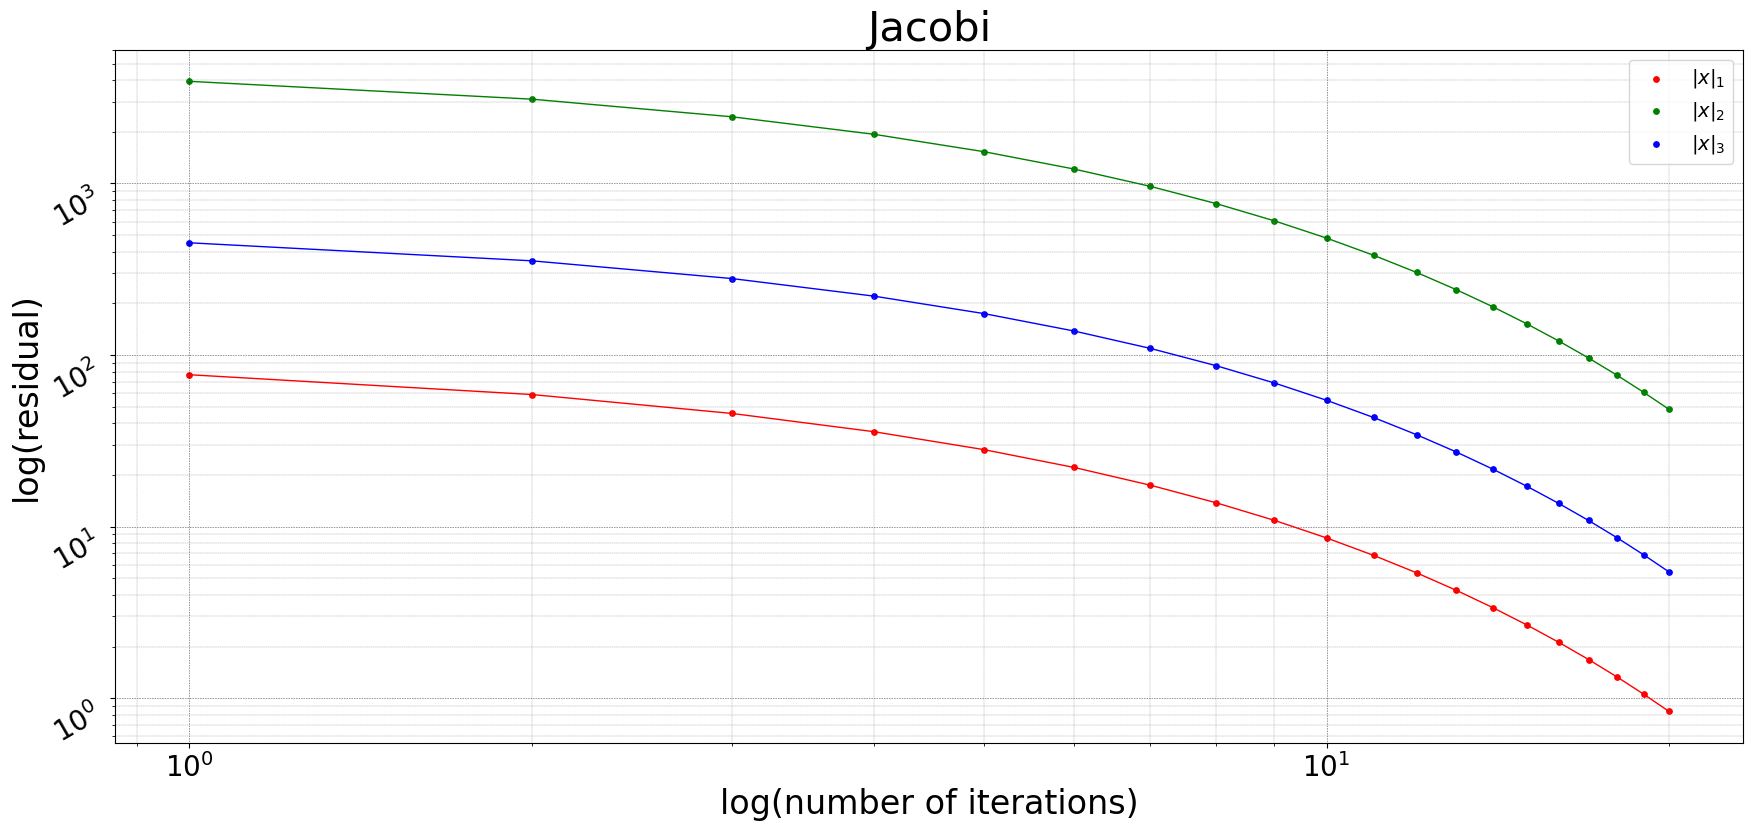

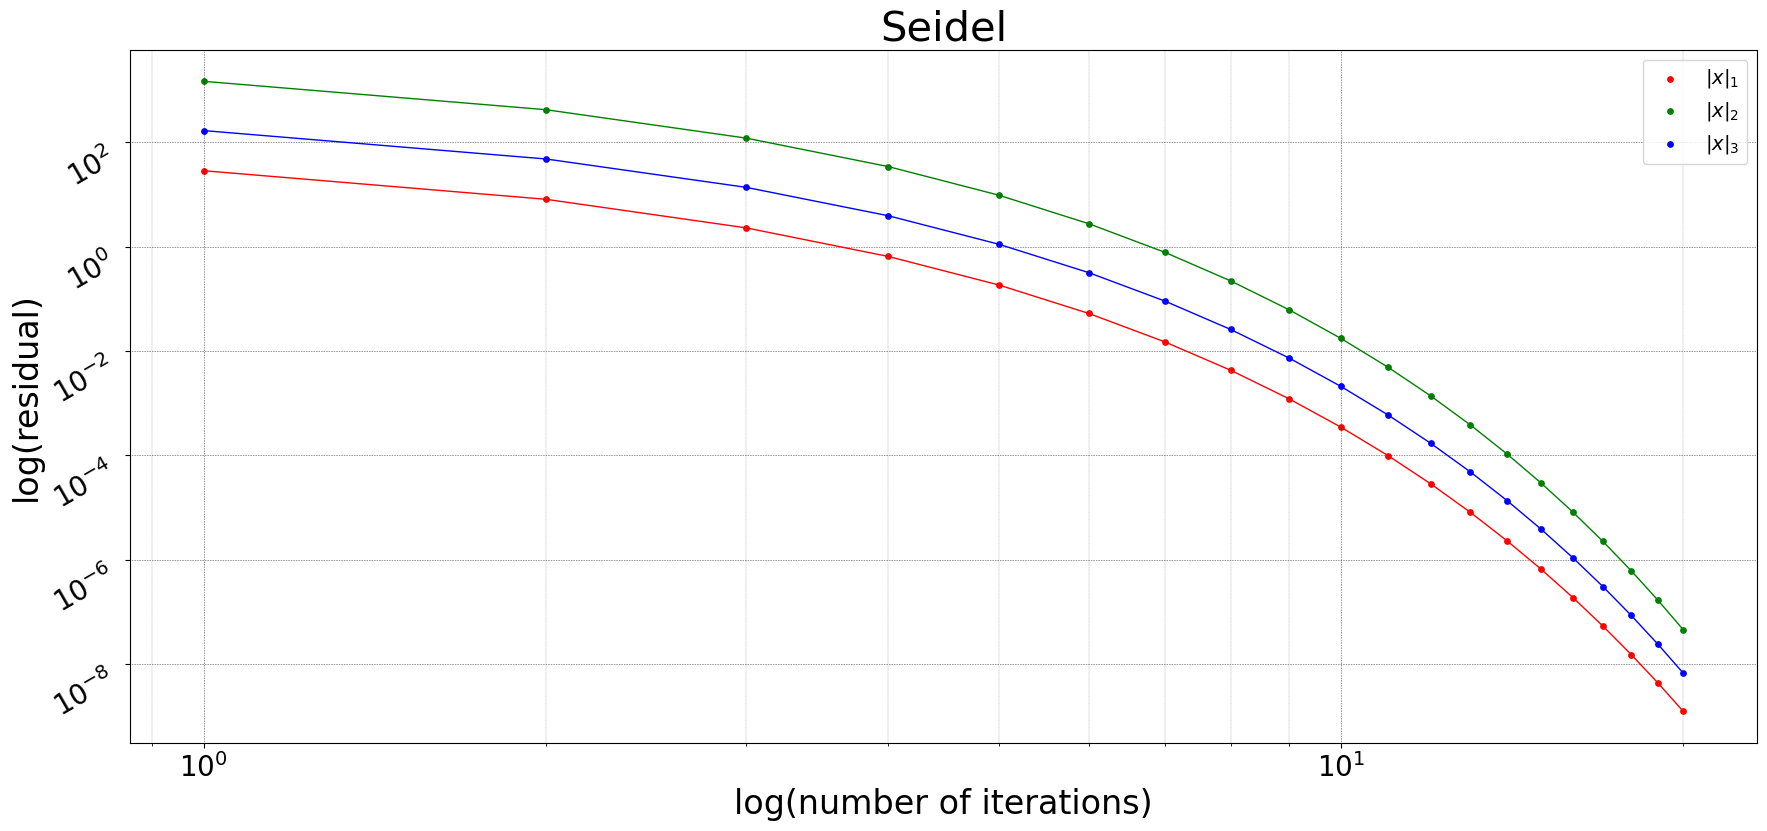

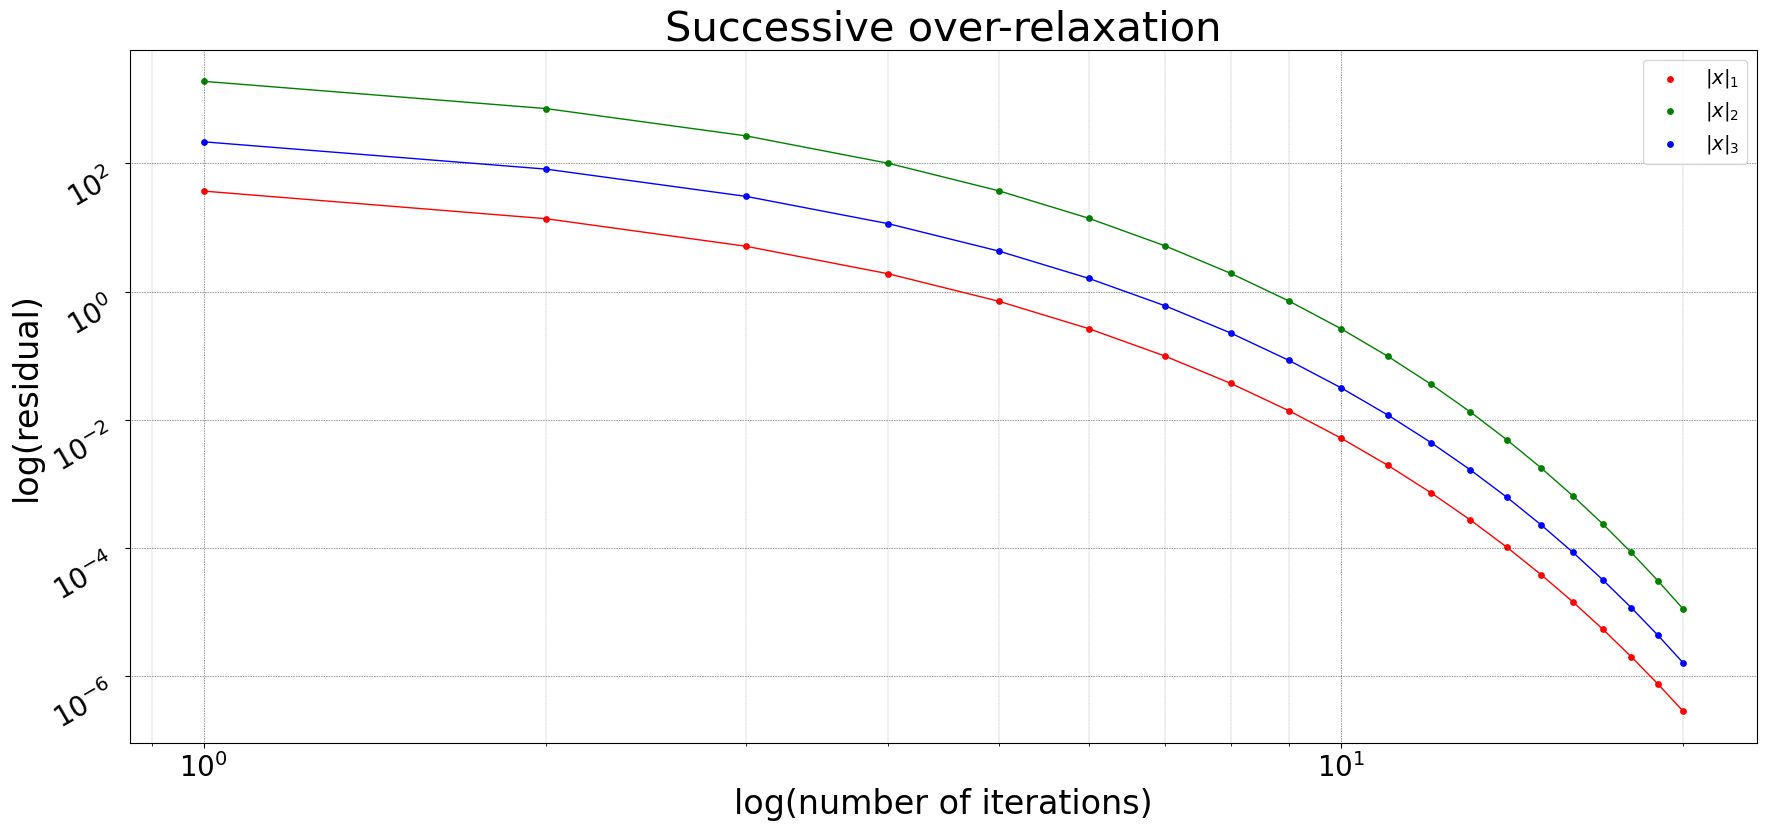

In [20]:
n_iters = 20

methods_list = [Iter_Method(Jacobi_method, "Jacobi"),
                Iter_Method(Seidel_method, "Seidel"),
                Iter_Method(successive_over_relaxation, "Successive over-relaxation")]

for method in methods_list:

    plt.figure (figsize = (21, 9), dpi = 100)
    plt.title(method.name_, fontsize=30)

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("log(number of iterations)", fontsize = 24)
    plt.xticks (fontsize = 20, ha = "center", va = "top")

    plt.ylabel("log(residual)", fontsize = 24)
    plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

    iters = np.arange(1, n_iters + 1)
    for norm in norms_list:
        residuals = []
        for i in iters:
            residuals.append(iterative_method_residual(A, b, method.method_, i, norm.formula_))

        plt.scatter (iters, residuals, s = 15, color = norm.color_, label = norm.name_)
        plt.plot (iters, residuals, color=norm.color_, linewidth = 1)

    plt.legend (loc = "best", fontsize = 14)

    plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
    plt.minorticks_on()
    plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

    plt.show()